In [1]:
# Importing necessary Libraries
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings

from scipy.stats import kurtosis, skew

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

## Dataset

In [3]:
# Reading Train data
train_beneficiary = pl.read_csv("../data/Train_Beneficiarydata.csv")
train_inpatient = pl.read_csv("../data/Train_Inpatientdata.csv", ignore_errors=True)
train_outpatient = pl.read_csv("../data/Train_Outpatientdata.csv")
train = pl.read_csv("../data/Train.csv")

# Reading Test data
test_beneficiary = pl.read_csv("../data/Test_Beneficiarydata.csv")
test_inpatient = pl.read_csv("../data/Test_Inpatientdata.csv", ignore_errors=True)
test_outpatient = pl.read_csv("../data/Test_Outpatientdata.csv")
test = pl.read_csv("../data/Test.csv")

In [4]:
train_inpatient = train_inpatient.with_columns(
    pl.lit(1).alias("Admitted?")
)

train_outpatient = train_outpatient.with_columns(
    pl.lit(0).alias("Admitted?")
)

In [5]:
common_cols = list(set(train_inpatient.columns).intersection(set(train_outpatient.columns)))
print(f"Number of common columns: {len(common_cols)}")

Number of common columns: 28


In [6]:
train_inpatient = train_inpatient.with_columns([
    pl.col("ClmDiagnosisCode_1").cast(pl.Utf8),
    pl.col("DeductibleAmtPaid").cast(pl.Utf8)
])

train_outpatient = train_outpatient.with_columns([
    pl.col("ClmDiagnosisCode_1").cast(pl.Utf8),
    pl.col("DeductibleAmtPaid").cast(pl.Utf8)
])

Here I am joining the inpatients and outpatients data

In [7]:
# joining the inpatients data and the out patients data
train_inpatient_outpatient = pl.concat([train_inpatient, train_outpatient], how="diagonal")

In [8]:
print(train_inpatient_outpatient.shape)

(558211, 31)


Here I am joining the inpatients, the outpatients and the beneficiary data

In [9]:
# joining the inpatients, outpatients data with the beneficiary data
train_ip_op_bene = train_inpatient_outpatient.join(
    train_beneficiary,
    on="BeneID",
    how="inner"
)

In [10]:
print(train_ip_op_bene.shape)

(558211, 55)


Here I am joining with the provider labels

In [11]:
# joining the provider and labels
full_train_data = train_ip_op_bene.join(
    train,
    on="Provider",
    how="inner"
)

In [12]:
print(full_train_data.shape)

(558211, 56)


In [13]:
print("Unique Providers:", full_train_data["Provider"].n_unique())
print("Unique Claim IDs:", full_train_data["ClaimID"].n_unique())

Unique Providers: 5410
Unique Claim IDs: 558211


**ASSUMPTION**
A single provider can be associated with multiple claims. However, assuming that all claims filed by a provider flagged as potentially fraudulent are themselves fraudulent is an overgeneralization.

- For example, a provider may have filed 50 claims, but only 1 or 2 of them could be fraudulent.

- Patterns of fraud can be subtle and may not extend across every claim submitted by the same provider.

**Conclusion**
It is not accurate to assume that all claims from a flagged provider are fraudulent. Each claim should be assessed on its own merits, possibly using claim-level features or additional investigation.

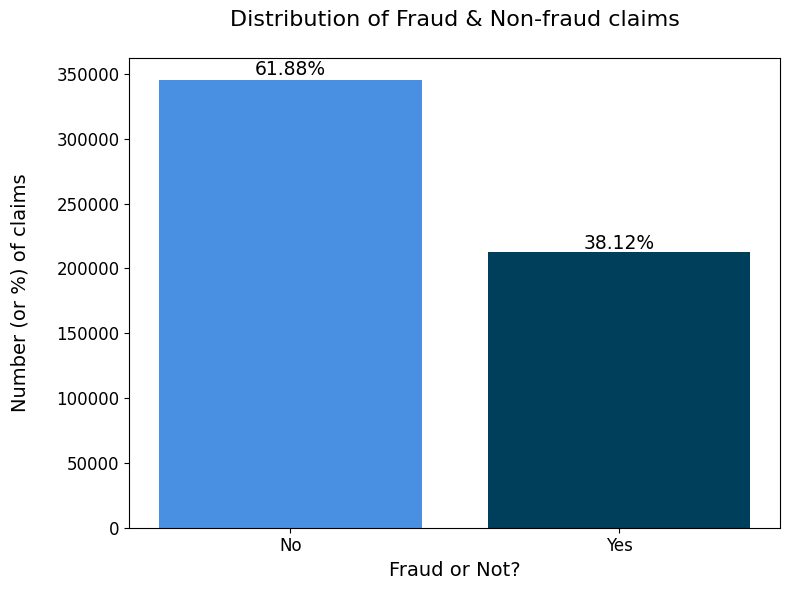

In [14]:
fraud_counts = full_train_data.group_by("PotentialFraud").agg([
    pl.count().alias("Count")
]).sort("PotentialFraud")


fraud_counts_pd = fraud_counts.to_pandas()


fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(fraud_counts_pd["PotentialFraud"], fraud_counts_pd["Count"], color=["#4A90E2", "#003f5c"])


total = fraud_counts_pd["Count"].sum()
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{round((height * 100) / total, 2)}%',
                xy=(bar.get_x() + bar.get_width() / 2, height * 1.01),
                ha='center', fontsize=13.5)

ax.set_xlabel("Fraud or Not?", fontsize=14)
ax.set_ylabel("Number (or %) of claims\n", fontsize=14)
ax.set_title("Distribution of Fraud & Non-fraud claims\n", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
full_train_data.write_csv("../data/merged_data_precleaned.csv")

### Feature Engineering

Here I am creating new features which are not present in the dataset, which I feel might be usefull in the data modeling.

1. First Converted the DOB, DOD, ClaimStartDt, ClaimEndDt, AdmissionDt, DischargeDt columns to datetime format
2. Then created a new feature called "Is_Alive" which is a binary feature, where 1 means the beneficiary is alive and 0 means the beneficiary is dead
3. Then created a new feature called "Claim_Duration" which is the duration of the claim in days

In [16]:
full_train_data = full_train_data.with_columns([
    pl.col("DOB").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("DOD").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("ClaimStartDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("ClaimEndDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("AdmissionDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("DischargeDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])


full_train_data = full_train_data.with_columns(
    pl.when(pl.col("DOD").is_null())
    .then(pl.lit("Yes"))
    .otherwise(pl.lit("No"))
    .alias("Is_Alive")
)

In [17]:
full_train_data = full_train_data.with_columns(
    (pl.col("ClaimEndDt") - pl.col("ClaimStartDt")).dt.total_days().alias("Claim_Duration")
)

In [18]:
full_train_data.select(
    pl.col("Is_Alive").value_counts()
)

Is_Alive
struct[2]
"{""No"",4131}"
"{""Yes"",554080}"


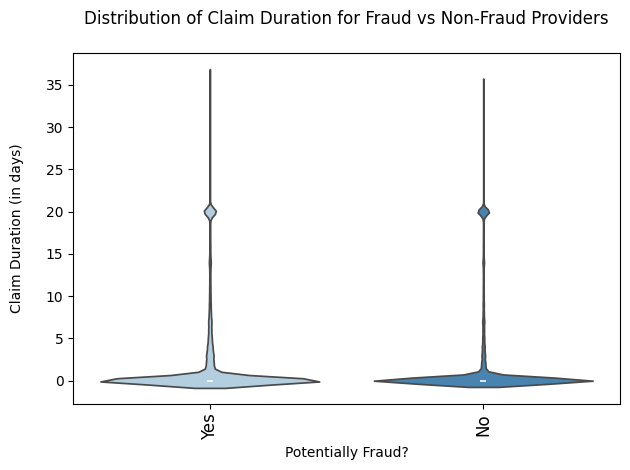

In [19]:
df_pd = full_train_data.select(["PotentialFraud", "Claim_Duration", "Gender", "Is_Alive"]).to_pandas()

fig = sns.violinplot(data=df_pd, x='PotentialFraud', y='Claim_Duration', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()


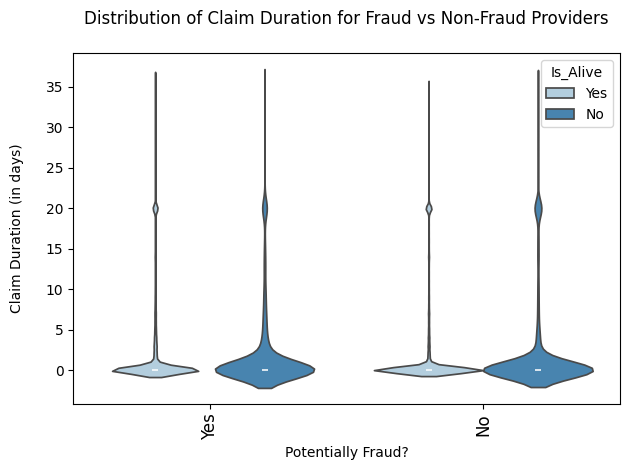

In [20]:
fig = sns.violinplot(data=df_pd, x='PotentialFraud', y='Claim_Duration', hue='Is_Alive', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()

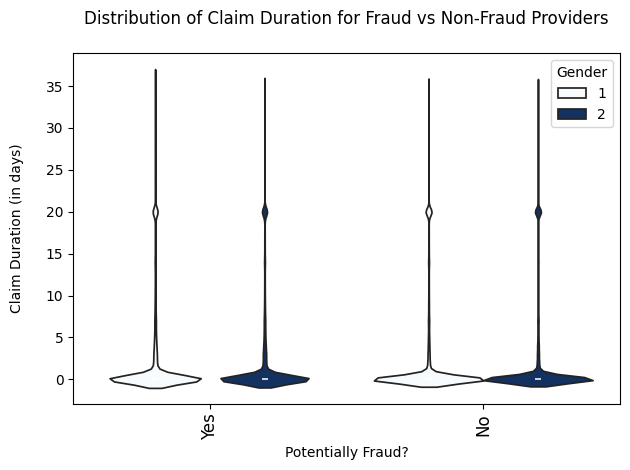

In [21]:
fig = sns.violinplot(data=df_pd, x='PotentialFraud', y='Claim_Duration', hue='Gender', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()

4. Then created a new feature called "Admitted_Duration" which is the duration of the admission in days

In [22]:
full_train_data = full_train_data.with_columns(
    (pl.col("DischargeDt") - pl.col("AdmissionDt"))
    .dt.total_days()
    .alias("Admitted_Duration")
)

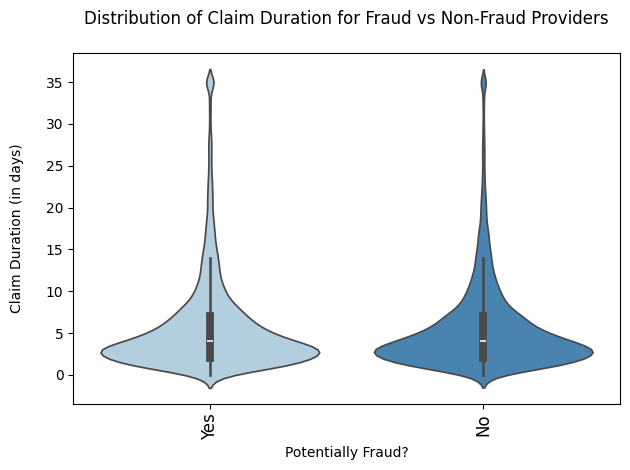

In [23]:
ad_pd = full_train_data.select(["PotentialFraud", "Admitted_Duration", "Gender", "Is_Alive"]).to_pandas()

fig = sns.violinplot(data=ad_pd, x='PotentialFraud', y='Admitted_Duration', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()

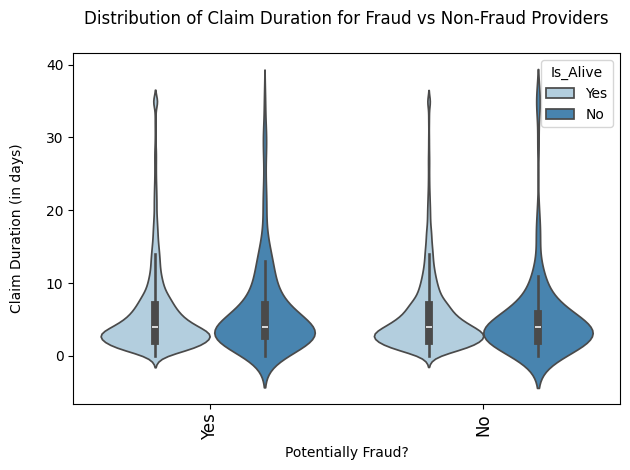

In [24]:
fig = sns.violinplot(data=ad_pd, x='PotentialFraud', y='Admitted_Duration', hue='Is_Alive', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()

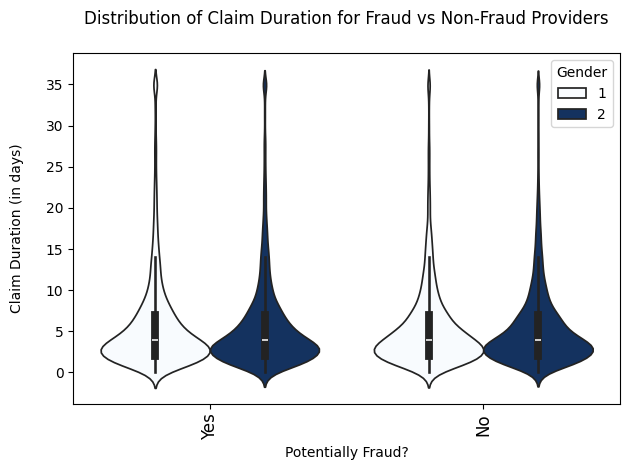

In [25]:
fig = sns.violinplot(data=ad_pd, x='PotentialFraud', y='Admitted_Duration', hue='Gender', palette='Blues')

plt.xlabel("Potentially Fraud?")
plt.xticks(rotation=90, fontsize=12)
plt.ylabel("Claim Duration (in days)\n")
plt.title("Distribution of Claim Duration for Fraud vs Non-Fraud Providers\n")
plt.tight_layout()
plt.show()

5. Here Age is calculated by subtracting DOB from DOD
6. Fixed DOD null values by using the max DOD value


In [26]:
max_dod = full_train_data.select(pl.col("DOD").drop_nulls().max()).item()

full_train_data = full_train_data.with_columns(
    pl.col("DOD").fill_null(pl.lit(max_dod))
)

In [27]:
full_train_data = full_train_data.with_columns(
    pl.when(pl.col("DOD").is_not_null())
    .then(((pl.col("DOD") - pl.col("DOB")).dt.total_days() / 365.0).round(1))
    .alias("AGE")
)

In [28]:
zero_reimb_admits = full_train_data.filter(
    (pl.col("IPAnnualReimbursementAmt") == 0) & (pl.col("Admitted?") == 1)
)

result = zero_reimb_admits.select(
    pl.col("PotentialFraud").value_counts().sort(descending=True)
)

result

PotentialFraud
struct[2]
"{""Yes"",249}"
"{""No"",164}"


In [29]:
zero_op_non_admit = full_train_data.filter(
    (pl.col("OPAnnualReimbursementAmt") == 0) & (pl.col("Admitted?") == 0)
)

result = zero_op_non_admit.select(
    pl.col("PotentialFraud").value_counts().sort(descending=True)
)

result

PotentialFraud
struct[2]
"{""Yes"",392}"
"{""No"",617}"


7. `Att_Phy_tot_claims` — representing the total number of claims handled by each attending physician.
8. `Opr_Phy_tot_claims` — total claims per Operating Physician.
9. `Oth_Phy_tot_claims` — total claims per Other Physician.
10. `Att_Opr_Oth_Phy_Tot_Claims` — the sum of all claims associated with any physician on the claim (attending + operating + other).


In [30]:
physician_claim_counts = full_train_data.group_by("AttendingPhysician").agg(
    pl.count("ClaimID").alias("Att_Phy_tot_claims")
)

full_train_data = full_train_data.join(
    physician_claim_counts,
    on="AttendingPhysician",
    how="left"
)

In [31]:
opr_claim_counts = full_train_data.group_by("OperatingPhysician").agg(
    pl.count("ClaimID").alias("Opr_Phy_tot_claims")
)

full_train_data = full_train_data.join(
    opr_claim_counts,
    on="OperatingPhysician",
    how="left"
)

In [32]:
oth_claim_counts = full_train_data.group_by("OtherPhysician").agg(
    pl.count("ClaimID").alias("Oth_Phy_tot_claims")
)

full_train_data = full_train_data.join(
    oth_claim_counts,
    on="OtherPhysician",
    how="left"
)

In [33]:
ull_train_data = full_train_data.with_columns([
    pl.col("Att_Phy_tot_claims").fill_null(0),
    pl.col("Opr_Phy_tot_claims").fill_null(0),
    pl.col("Oth_Phy_tot_claims").fill_null(0)
])

full_train_data = full_train_data.with_columns(
    (pl.col("Att_Phy_tot_claims") +
     pl.col("Opr_Phy_tot_claims") +
     pl.col("Oth_Phy_tot_claims")).alias("Att_Opr_Oth_Phy_Tot_Claims")
)

"Prv_Tot_Att_Phy" — total claims with Attending Physician per provider

"Prv_Tot_Opr_Phy" — total claims with Operating Physician per provider

"Prv_Tot_Oth_Phy" — total claims with Other Physician per provider

"Prv_Tot_Att_Opr_Oth_Phys" — combined total claims with attending, operating, and other physicians per provider

In [34]:
att_counts = full_train_data.group_by("Provider").agg(
    pl.count("AttendingPhysician").alias("Prv_Tot_Att_Phy")
)

opr_counts = full_train_data.group_by("Provider").agg(
    pl.count("OperatingPhysician").alias("Prv_Tot_Opr_Phy")
)

oth_counts = full_train_data.group_by("Provider").agg(
    pl.count("OtherPhysician").alias("Prv_Tot_Oth_Phy")
)

full_train_data = (
    full_train_data
    .join(att_counts, on="Provider", how="left")
    .join(opr_counts, on="Provider", how="left")
    .join(oth_counts, on="Provider", how="left")
)

In [35]:
full_train_data = full_train_data.with_columns(
    (pl.col("Prv_Tot_Att_Phy") +
     pl.col("Prv_Tot_Opr_Phy") +
     pl.col("Prv_Tot_Oth_Phy")).alias("Prv_Tot_Att_Opr_Oth_Phys")
)

**New Features Added:**

PRV_Tot_Admit_DCodes – diversity of admitting diagnoses per provider

PRV_Tot_DGrpCodes – diversity of diagnosis groups per provider

PRV_Tot_Unq_DOB_Years – number of unique years of birth across a provider’s patients.

In [36]:
admit_dcode_counts = full_train_data.group_by("Provider").agg(
    pl.col("ClmAdmitDiagnosisCode").n_unique().alias("PRV_Tot_Admit_DCodes")
)

full_train_data = full_train_data.join(
    admit_dcode_counts,
    on="Provider",
    how="left"
)

In [37]:
diag_grp_counts = full_train_data.group_by("Provider").agg(
    pl.col("DiagnosisGroupCode").n_unique().alias("PRV_Tot_DGrpCodes")
)

full_train_data = full_train_data.join(
    diag_grp_counts,
    on="Provider",
    how="left"
)

In [38]:
full_train_data = full_train_data.with_columns(
    pl.col("DOB").dt.year().alias("DOB_Year")
)

unique_dob_years = full_train_data.group_by("Provider").agg(
    pl.col("DOB_Year").n_unique().alias("PRV_Tot_Unq_DOB_Years")
)

full_train_data = full_train_data.join(
    unique_dob_years,
    on="Provider",
    how="left"
)

In [39]:
full_train_data.filter(pl.col("PRV_Tot_Unq_DOB_Years") >= 67).select(pl.col("PotentialFraud").value_counts().sort(descending=True))

PotentialFraud
struct[2]
"{""Yes"",118873}"
"{""No"",22203}"


PRV_Bene_Age_Sum — total patient age

PRV_Insc_Clm_ReImb_Amt — total insurance reimbursement

PRV_Tot_RKD_Patients — number of renal disease patients

In [40]:
bene_age_sum = full_train_data.group_by("Provider").agg(
    pl.col("AGE").sum().alias("PRV_Bene_Age_Sum")
)

full_train_data = full_train_data.join(
    bene_age_sum,
    on="Provider",
    how="left"
)

In [41]:
insc_reimb_sum = full_train_data.group_by("Provider").agg(
    pl.col("InscClaimAmtReimbursed").sum().alias("PRV_Insc_Clm_ReImb_Amt")
)

full_train_data = full_train_data.join(
    insc_reimb_sum,
    on="Provider",
    how="left"
)

In [42]:
full_train_data = full_train_data.with_columns(
    (pl.col("RenalDiseaseIndicator") == "Y").cast(pl.Int8).alias("RenalDiseaseIndicator")
)

renal_disease_sum = full_train_data.group_by("Provider").agg(
    pl.col("RenalDiseaseIndicator").sum().alias("PRV_Tot_RKD_Patients")
)

full_train_data = full_train_data.join(
    renal_disease_sum,
    on="Provider",
    how="left"
)

In [43]:
full_train_data = full_train_data.with_columns(
    pl.col("Admitted_Duration").fill_null(0)
)

PRV_CoPayment - Total patient deductible/copayment paid

PRV_IP_Annual_ReImb_Amt - Inpatient reimbursement total

PRV_IP_Annual_Ded_Amt - Inpatient deductible total

PRV_OP_Annual_ReImb_Amt - Outpatient reimbursement total

PRV_OP_Annual_Ded_Amt - Outpatient deductible total

PRV_Admit_Duration - Sum of admitted stay durations

PRV_Claim_Duration - Total length of all claims

In [44]:
agg_df = full_train_data.group_by("Provider").agg([
    pl.col("DeductibleAmtPaid").sum().alias("PRV_CoPayment"),
    pl.col("IPAnnualReimbursementAmt").sum().alias("PRV_IP_Annual_ReImb_Amt"),
    pl.col("IPAnnualDeductibleAmt").sum().alias("PRV_IP_Annual_Ded_Amt"),
    pl.col("OPAnnualReimbursementAmt").sum().alias("PRV_OP_Annual_ReImb_Amt"),
    pl.col("OPAnnualDeductibleAmt").sum().alias("PRV_OP_Annual_Ded_Amt"),
    pl.col("Admitted_Duration").sum().alias("PRV_Admit_Duration"),
    pl.col("Claim_Duration").sum().alias("PRV_Claim_Duration")
])

full_train_data = full_train_data.join(agg_df, on="Provider", how="left")

In [45]:
def create_agg_feats_polars(df: pl.DataFrame, grp_col: str, feat_name: str, operation: str = "sum") -> pl.DataFrame:
    """
    Generate aggregated features at a group level using Polars.

    Parameters:
    - df : Polars DataFrame
    - grp_col : column to group by (str)
    - feat_name : prefix for new features (str)
    - operation : aggregation method - 'sum', 'mean', etc. (default = 'sum')
    
    Returns:
    - df : Polars DataFrame with new features joined
    """
    agg_exprs = []

    columns_to_agg = [
        ("InscClaimAmtReimbursed", "_Insc_ReImb_Amt"),
        ("DeductibleAmtPaid", "_CoPayment"),
        ("IPAnnualReimbursementAmt", "_IP_Annual_ReImb_Amt"),
        ("IPAnnualDeductibleAmt", "_IP_Annual_Ded_Amt"),
        ("OPAnnualReimbursementAmt", "_OP_Annual_ReImb_Amt"),
        ("OPAnnualDeductibleAmt", "_OP_Annual_Ded_Amt"),
        ("Admitted_Duration", "_Admit_Duration"),
        ("Claim_Duration", "_Claim_Duration")
    ]

    for col, suffix in columns_to_agg:
        agg_col_name = f"{feat_name}{suffix}"
        expr = getattr(pl.col(col), operation)().alias(agg_col_name)
        agg_exprs.append(expr)

    # Create aggregation DataFrame
    agg_df = df.group_by(grp_col).agg(agg_exprs)

    # Join back to main DataFrame
    df = df.join(agg_df, on=grp_col, how="left")

    return df

#### Grouped by `BeneID` (Prefix: `BENE_`)

| Feature Name                | Description                                                                |
|-----------------------------|----------------------------------------------------------------------------|
| BENE_Insc_ReImb_Amt         | Total reimbursed claim amount for each beneficiary.                        |
| BENE_CoPayment              | Total deductible amount paid by each beneficiary.                          |
| BENE_IP_Annual_ReImb_Amt    | Total inpatient annual reimbursement for the beneficiary.                 |
| BENE_IP_Annual_Ded_Amt      | Total inpatient annual deductible paid by the beneficiary.                 |
| BENE_OP_Annual_ReImb_Amt    | Total outpatient annual reimbursement for the beneficiary.                |
| BENE_OP_Annual_Ded_Amt      | Total outpatient annual deductible paid by the beneficiary.                |
| BENE_Admit_Duration         | Total number of days admitted across all claims for the beneficiary.      |
| BENE_Claim_Duration         | Total claim duration (discharge - admission) across claims.               |


#### Grouped by `ClmAdmitDiagnosisCode` (Prefix: `Claim_Admit_Diag_Code_`)

| Feature Name                          | Description                                                           |
|---------------------------------------|-----------------------------------------------------------------------|
| Claim_Admit_Diag_Code_Insc_ReImb_Amt | Total reimbursement for the admit diagnosis code.                    |
| Claim_Admit_Diag_Code_CoPayment      | Total deductible paid for this diagnosis code.                       |
| Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt | Total inpatient reimbursement for the admit diagnosis code.      |
| Claim_Admit_Diag_Code_IP_Annual_Ded_Amt | Total inpatient deductibles for the admit diagnosis code.         |
| Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt | Total outpatient reimbursement for the admit diagnosis code.     |
| Claim_Admit_Diag_Code_OP_Annual_Ded_Amt | Total outpatient deductibles for the admit diagnosis code.         |
| Claim_Admit_Diag_Code_Admit_Duration | Total admitted days for the diagnosis code.                         |
| Claim_Admit_Diag_Code_Claim_Duration | Total claim duration for the diagnosis code.                        |

#### Grouped by `DiagnosisGroupCode` (Prefix: `Diag_GCode_`)

| Feature Name                          | Description                                                           |
|---------------------------------------|-----------------------------------------------------------------------|
| Diag_GCode_Insc_ReImb_Amt            | Total reimbursement for the diagnosis group.                         |
| Diag_GCode_CoPayment                 | Total deductible paid for this diagnosis group.                      |
| Diag_GCode_IP_Annual_ReImb_Amt       | Total inpatient reimbursement for the diagnosis group.               |
| Diag_GCode_IP_Annual_Ded_Amt         | Total inpatient deductibles for the diagnosis group.                 |
| Diag_GCode_OP_Annual_ReImb_Amt       | Total outpatient reimbursement for the diagnosis group.              |
| Diag_GCode_OP_Annual_Ded_Amt         | Total outpatient deductibles for the diagnosis group.                |
| Diag_GCode_Admit_Duration            | Total admitted days for the diagnosis group.                         |
| Diag_GCode_Claim_Duration            | Total claim duration for the diagnosis group.                        |


In [46]:
full_train_data = create_agg_feats_polars(full_train_data, grp_col="BeneID", feat_name="BENE")
# full_train_data = create_agg_feats_polars(full_train_data, grp_col="AttendingPhysician", feat_name="ATT_PHY")
# full_train_data = create_agg_feats_polars(full_train_data, grp_col="OperatingPhysician", feat_name="OPT_PHY")
# full_train_data = create_agg_feats_polars(full_train_data, grp_col="OtherPhysician", feat_name="OTH_PHY")
full_train_data = create_agg_feats_polars(full_train_data, grp_col="ClmAdmitDiagnosisCode", feat_name="Claim_Admit_Diag_Code")
full_train_data = create_agg_feats_polars(full_train_data, grp_col="DiagnosisGroupCode", feat_name="Diag_GCode")

In [47]:
full_train_data = full_train_data.drop([
    "Att_Phy_tot_claims", "Opr_Phy_tot_claims", "Oth_Phy_tot_claims", "DOB_Year", 
    "Prv_Tot_Att_Phy", "Prv_Tot_Opr_Phy", "Prv_Tot_Oth_Phy",
    "NoOfMonths_PartACov", "NoOfMonths_PartBCov",
    "ClmProcedureCode_4", "ClmProcedureCode_5", "ClmProcedureCode_6"
])

In [48]:
print(full_train_data.shape)

(558211, 94)


In [49]:
def add_claim_counts(df: pl.DataFrame, group_cols: list[str]) -> pl.DataFrame:
    """
    Adds a column representing the count of ClaimID per group of columns.

    Parameters:
    - df: Polars DataFrame
    - group_cols: list of columns to group by

    Returns:
    - df with the new claim count column
    """
    col_name = "ClmCount_" + "_".join(group_cols)
    count_df = df.group_by(group_cols).agg(
        pl.count("ClaimID").alias(col_name)
    )
    return df.join(count_df, on=group_cols, how="left")


In [50]:
groupings = [
    ["Provider"], 
    ["Provider", "BeneID"], 
    ["Provider", "AttendingPhysician"], 
    ["Provider", "BeneID", "AttendingPhysician"], 
    ["Provider", "ClmAdmitDiagnosisCode"], 
]

for gcols in groupings:
    full_train_data = add_claim_counts(full_train_data, gcols)

In [51]:
remove_unwanted_columns = [
    'BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
    'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
    'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
    'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
    'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
    'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County'
]

full_train_data = full_train_data.drop(remove_unwanted_columns)

In [52]:
print(full_train_data.shape)

(558211, 71)


In [53]:
full_train_data = full_train_data.with_columns(
    pl.when(pl.col("DeductibleAmtPaid").is_in(["NA", "NaN", ""]))
      .then(None)
      .otherwise(pl.col("DeductibleAmtPaid"))
      .alias("DeductibleAmtPaid")
)

full_train_data = full_train_data.with_columns(
    pl.col("DeductibleAmtPaid").fill_null(0)
)


In [54]:
power_bi_data = full_train_data.clone()

In [55]:
full_train_data = full_train_data.with_columns([
    pl.when(pl.col("Gender") == 2).then(0).otherwise(pl.col("Gender")).alias("Gender"),
    pl.col("PotentialFraud").replace({"No": 0, "Yes": 1}).alias("PotentialFraud"),
    pl.col("Is_Alive").replace({"No": 0, "Yes": 1}).alias("Is_Alive?"),
    pl.when(pl.col("ChronicCond_Alzheimer") == 2).then(0).otherwise(pl.col("ChronicCond_Alzheimer")).alias("ChronicCond_Alzheimer"),
    pl.when(pl.col("ChronicCond_Heartfailure") == 2).then(0).otherwise(pl.col("ChronicCond_Heartfailure")).alias("ChronicCond_Heartfailure"),
    pl.when(pl.col("ChronicCond_KidneyDisease") == 2).then(0).otherwise(pl.col("ChronicCond_KidneyDisease")).alias("ChronicCond_KidneyDisease"),
    pl.when(pl.col("ChronicCond_Cancer") == 2).then(0).otherwise(pl.col("ChronicCond_Cancer")).alias("ChronicCond_Cancer"),
    pl.when(pl.col("ChronicCond_ObstrPulmonary") == 2).then(0).otherwise(pl.col("ChronicCond_ObstrPulmonary")).alias("ChronicCond_ObstrPulmonary"),
    pl.when(pl.col("ChronicCond_Depression") == 2).then(0).otherwise(pl.col("ChronicCond_Depression")).alias("ChronicCond_Depression"),
    pl.when(pl.col("ChronicCond_Diabetes") == 2).then(0).otherwise(pl.col("ChronicCond_Diabetes")).alias("ChronicCond_Diabetes"),
    pl.when(pl.col("ChronicCond_IschemicHeart") == 2).then(0).otherwise(pl.col("ChronicCond_IschemicHeart")).alias("ChronicCond_IschemicHeart"),
    pl.when(pl.col("ChronicCond_Osteoporasis") == 2).then(0).otherwise(pl.col("ChronicCond_Osteoporasis")).alias("ChronicCond_Osteoporasis"),
    pl.when(pl.col("ChronicCond_rheumatoidarthritis") == 2).then(0).otherwise(pl.col("ChronicCond_rheumatoidarthritis")).alias("ChronicCond_rheumatoidarthritis"),
    pl.when(pl.col("ChronicCond_stroke") == 2).then(0).otherwise(pl.col("ChronicCond_stroke")).alias("ChronicCond_stroke"),
])


In [56]:
categorical_cols = ["Gender", "Race", "Admitted?", "Is_Alive"]
for col in categorical_cols:
    dummies = full_train_data.select([col]).to_dummies()

    keep_cols = [c for c in dummies.columns if not c.endswith("_0")]
    dummies = dummies.select(keep_cols)

    full_train_data = full_train_data.hstack(dummies)

full_train_data = full_train_data.drop(categorical_cols)

In [57]:
columns_to_remove = [
    "PRV_CoPayment", 
    "BENE_CoPayment", 
    "Claim_Admit_Diag_Code_CoPayment",
    "Diag_GCode_CoPayment",
    "Diag_GCode_IP_Annual_ReImb_Amt",
    "Diag_GCode_Insc_ReImb_Amt", 
    "Diag_GCode_IP_Annual_Ded_Amt", 
    "Diag_GCode_OP_Annual_ReImb_Amt", 
    "Diag_GCode_OP_Annual_Ded_Amt", 
    "Diag_GCode_Admit_Duration", 
    "Diag_GCode_Claim_Duration"
]

full_train_data = full_train_data.drop(columns_to_remove)

In [58]:
full_train_data = full_train_data.with_columns(
    [pl.col(col).cast(pl.Int64).alias(col) for col in full_train_data.columns if col != "Provider"]
)

In [59]:
def get_stats(df):
    """
    Generates a comprehensive statistical summary of a Polars DataFrame.

    This function analyzes each column of the provided Polars DataFrame `df`
    and returns a summary containing:
      - Column names
      - Data types
      - Count of non-null values
      - Count of null values
      - Percentage of missing values
      - Number of unique values
      - Sample unique values
      - Kurtosis (for numeric columns)
      - Skewness (for numeric columns)

    Parameters:
    -----------
    df : pl.DataFrame
        The input Polars DataFrame to analyze.

    Returns:
    --------
    pl.DataFrame
        A summary DataFrame with the statistics for each column in the input DataFrame.
    """
    df = df.with_columns([
        pl.when(pl.col(col) == "NA").then(None).otherwise(pl.col(col)).alias(col)
        if df[col].dtype == pl.Utf8 else df[col]
        for col in df.columns
    ])
    
    n_rows = df.shape[0]
    columns = df.columns
    dtypes = df.dtypes
    total_cnt = df.select(pl.col("*").drop_nulls().count())
    null_cnt = df.select([
        (n_rows - pl.col(col).drop_nulls().count()).alias(f"{col}_null_count")
        for col in df.columns
    ])
    missing_perc = null_cnt.with_columns([
        (pl.col(col) / n_rows * 100).alias(f"{col}_missing_percentage")
        for col in null_cnt.columns
    ])
    unq_vals = {col: df[col].n_unique() for col in df.columns}
    total_unqs = {col: df[col].unique().to_list() for col in df.columns}
    numeric_cols = df.select(pl.col(pl.Int64) | pl.col(pl.Float64))

    if numeric_cols.columns:
        kurtosis_vals = {}
        skewness_vals = {}

        for col in numeric_cols.columns:
            data = numeric_cols.select(pl.col(col)).to_numpy().flatten()
            kurtosis_vals[col] = kurtosis(data)
            skewness_vals[col] = skew(data)

        kurtosis_list = [kurtosis_vals.get(col, None) for col in df.columns]
        skewness_list = [skewness_vals.get(col, None) for col in df.columns]
    else:
        kurtosis_list = [None] * len(df.columns)
        skewness_list = [None] * len(df.columns)

    summary = pl.DataFrame({
        "Columns": columns,
        "Data Type": dtypes,
        "Non-Null count": [total_cnt[col][0] for col in df.columns],
        "Null count": [null_cnt[f"{col}_null_count"][0] for col in df.columns],
        "Missing Percentage (%)": [missing_perc[f"{col}_null_count_missing_percentage"][0] for col in df.columns],
        "Number of Unique Values": [unq_vals[col] for col in df.columns],
        "Sample Unique Values": [total_unqs[col] for col in df.columns]
    }, strict=False)

    summary = summary.with_columns([
        pl.Series("Kurtosis", kurtosis_list),
        pl.Series("Skewness", skewness_list)
    ])

    return summary

In [60]:
full_train_stats = get_stats(full_train_data)

In [61]:
full_train_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""Provider""",String,558211,0,0.0,5410,"[""PRV56622"", ""PRV54609"", … ""PRV56606""]",null,null
"""InscClaimAmtReimbursed""",Int64,558211,0,0.0,438,"[""0"", ""10"", … ""125000""]",136.579123,9.491398
"""DeductibleAmtPaid""",Int64,558211,0,0.0,17,"[""0"", ""10"", … ""1068""]",9.108032,3.327418
"""RenalDiseaseIndicator""",Int64,558211,0,0.0,2,"[""0"", ""1""]",0.326665,1.525341
"""ChronicCond_Alzheimer""",Int64,558211,0,0.0,2,"[""0"", ""1""]",-1.839748,0.400315
…,…,…,…,…,…,…,…,…
"""Race_3""",Int64,558211,0,0.0,2,"[""0"", ""1""]",23.350636,5.034942
"""Race_5""",Int64,558211,0,0.0,2,"[""0"", ""1""]",42.247606,6.651887
"""Admitted?_1""",Int64,558211,0,0.0,2,"[""0"", ""1""]",8.870017,3.296971


In [62]:
has_nulls = full_train_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(has_nulls.select(["Columns", "Null count", "Missing Percentage (%)"]))

Columns with null values:
shape: (0, 3)
┌─────────┬────────────┬────────────────────────┐
│ Columns ┆ Null count ┆ Missing Percentage (%) │
│ ---     ┆ ---        ┆ ---                    │
│ str     ┆ i64        ┆ f64                    │
╞═════════╪════════════╪════════════════════════╡
└─────────┴────────────┴────────────────────────┘


In [63]:
# Writing the data in file

full_train_data.write_csv("../data/merged_cleaned_insurance_data.csv")

In [64]:
full_train_data.filter(pl.col("Provider") == "PRV51459")

Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Claim_Duration,Admitted_Duration,AGE,Att_Opr_Oth_Phy_Tot_Claims,Prv_Tot_Att_Opr_Oth_Phys,PRV_Tot_Admit_DCodes,PRV_Tot_DGrpCodes,PRV_Tot_Unq_DOB_Years,PRV_Bene_Age_Sum,PRV_Insc_Clm_ReImb_Amt,PRV_Tot_RKD_Patients,PRV_IP_Annual_ReImb_Amt,PRV_IP_Annual_Ded_Amt,PRV_OP_Annual_ReImb_Amt,PRV_OP_Annual_Ded_Amt,PRV_Admit_Duration,PRV_Claim_Duration,BENE_Insc_ReImb_Amt,BENE_IP_Annual_ReImb_Amt,BENE_IP_Annual_Ded_Amt,BENE_OP_Annual_ReImb_Amt,BENE_OP_Annual_Ded_Amt,BENE_Admit_Duration,BENE_Claim_Duration,Claim_Admit_Diag_Code_Insc_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_IP_Annual_Ded_Amt,Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt,Claim_Admit_Diag_Code_OP_Annual_Ded_Amt,Claim_Admit_Diag_Code_Admit_Duration,Claim_Admit_Diag_Code_Claim_Duration,ClmCount_Provider,ClmCount_Provider_BeneID,ClmCount_Provider_AttendingPhysician,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_ClmAdmitDiagnosisCode,Is_Alive?,Gender_1,Race_1,Race_2,Race_3,Race_5,Admitted?_1,Is_Alive_No,Is_Alive_Yes
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""PRV51459""",60,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,370,90,1,0,0,78,803395,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,370,0,0,2590,630,0,0,2124920,3727050,276852,618290,181390,610,623,8240,5,1156,1,4,1,0,0,0,1,0,0,0,1
"""PRV51459""",100,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,370,90,1,0,0,78,445992,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,370,0,0,2590,630,0,0,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,5,1158,1,6555,1,0,0,0,1,0,0,0,1
"""PRV51459""",10,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,370,90,1,0,0,78,446043,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,370,0,0,2590,630,0,0,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,5,1181,2,6555,1,0,0,0,1,0,0,0,1
"""PRV51459""",40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,370,90,1,0,0,78,446043,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,370,0,0,2590,630,0,0,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,5,1181,2,6555,1,0,0,0,1,0,0,0,1
"""PRV51459""",70,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,370,90,1,0,0,78,446005,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,370,0,0,2590,630,0,0,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,5,1200,1,6555,1,0,0,0,1,0,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""PRV51459""",30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1430,260,1,3,0,76,803372,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,530,0,0,4290,780,0,3,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,3,1133,2,6555,1,1,1,0,0,0,0,0,1
"""PRV51459""",50,0,0,1,0,0,1,0,0,1,1,0,0,0,10010,1068,1250,500,1,0,0,79,2455,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,10420,50050,5340,6250,2500,1,1,780380,1475870,179880,226380,63370,750,809,8240,1,1133,1,3,1,1,0,1,0,0,0,0,1
"""PRV51459""",60,100,0,0,1,0,1,0,1,1,1,0,0,0,17140,1068,1230,1350,1,0,0,58,446043,24720,583,1,75,617454,2321890,1447,33978430,3924816,19098210,5456830,0,11542,17830,119980,7476,8610,9450,9,9,119225270,1712507730,186536486,969922310,275105309,0,638174,8240,1,1181,1,6555,1,0,1,0,0,0,0,0,1


### Power BI Data Exploration

In [65]:
power_bi_data = power_bi_data.with_columns([
    pl.when(pl.col("Gender") == 2).then(0).otherwise(pl.col("Gender")).alias("Gender"),
    pl.when(pl.col("ChronicCond_Alzheimer") == 2).then(0).otherwise(pl.col("ChronicCond_Alzheimer")).alias("ChronicCond_Alzheimer"),
    pl.when(pl.col("ChronicCond_Heartfailure") == 2).then(0).otherwise(pl.col("ChronicCond_Heartfailure")).alias("ChronicCond_Heartfailure"),
    pl.when(pl.col("ChronicCond_KidneyDisease") == 2).then(0).otherwise(pl.col("ChronicCond_KidneyDisease")).alias("ChronicCond_KidneyDisease"),
    pl.when(pl.col("ChronicCond_Cancer") == 2).then(0).otherwise(pl.col("ChronicCond_Cancer")).alias("ChronicCond_Cancer"),
    pl.when(pl.col("ChronicCond_ObstrPulmonary") == 2).then(0).otherwise(pl.col("ChronicCond_ObstrPulmonary")).alias("ChronicCond_ObstrPulmonary"),
    pl.when(pl.col("ChronicCond_Depression") == 2).then(0).otherwise(pl.col("ChronicCond_Depression")).alias("ChronicCond_Depression"),
    pl.when(pl.col("ChronicCond_Diabetes") == 2).then(0).otherwise(pl.col("ChronicCond_Diabetes")).alias("ChronicCond_Diabetes"),
    pl.when(pl.col("ChronicCond_IschemicHeart") == 2).then(0).otherwise(pl.col("ChronicCond_IschemicHeart")).alias("ChronicCond_IschemicHeart"),
    pl.when(pl.col("ChronicCond_Osteoporasis") == 2).then(0).otherwise(pl.col("ChronicCond_Osteoporasis")).alias("ChronicCond_Osteoporasis"),
    pl.when(pl.col("ChronicCond_rheumatoidarthritis") == 2).then(0).otherwise(pl.col("ChronicCond_rheumatoidarthritis")).alias("ChronicCond_rheumatoidarthritis"),
    pl.when(pl.col("ChronicCond_stroke") == 2).then(0).otherwise(pl.col("ChronicCond_stroke")).alias("ChronicCond_stroke"),
])

In [66]:
columns_to_drop = [
    "PRV_Tot_Unq_DOB_Years", "PRV_Bene_Age_Sum",
    "PRV_Tot_Admit_DCodes", "PRV_Tot_DGrpCodes",
    "Claim_Admit_Diag_Code_Insc_ReImb_Amt",
    "Claim_Admit_Diag_Code_IP_Annual_ReImb_Amt",
    "Claim_Admit_Diag_Code_IP_Annual_Ded_Amt",
    "Claim_Admit_Diag_Code_OP_Annual_ReImb_Amt",
    "Claim_Admit_Diag_Code_OP_Annual_Ded_Amt",
    "Claim_Admit_Diag_Code_Admit_Duration",
    "Claim_Admit_Diag_Code_Claim_Duration",
    "ClmCount_Provider_BeneID",
    "ClmCount_Provider_AttendingPhysician",
    "ClmCount_Provider_BeneID_AttendingPhysician",
    "ClmCount_Provider_ClmAdmitDiagnosisCode",
    "PRV_CoPayment", 
    "BENE_CoPayment", 
    "Claim_Admit_Diag_Code_CoPayment",
    "Diag_GCode_CoPayment",
    "Diag_GCode_IP_Annual_ReImb_Amt",
    "Diag_GCode_Insc_ReImb_Amt", 
    "Diag_GCode_IP_Annual_Ded_Amt", 
    "Diag_GCode_OP_Annual_ReImb_Amt", 
    "Diag_GCode_OP_Annual_Ded_Amt", 
    "Diag_GCode_Admit_Duration", 
    "Diag_GCode_Claim_Duration"
]

cleaned_df = power_bi_data.drop([col for col in columns_to_drop if col in power_bi_data.columns])

print(cleaned_df.columns)

['Provider', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'Admitted?', 'Gender', 'Race', 'RenalDiseaseIndicator', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'PotentialFraud', 'Is_Alive', 'Claim_Duration', 'Admitted_Duration', 'AGE', 'Att_Opr_Oth_Phy_Tot_Claims', 'Prv_Tot_Att_Opr_Oth_Phys', 'PRV_Insc_Clm_ReImb_Amt', 'PRV_Tot_RKD_Patients', 'PRV_IP_Annual_ReImb_Amt', 'PRV_IP_Annual_Ded_Amt', 'PRV_OP_Annual_ReImb_Amt', 'PRV_OP_Annual_Ded_Amt', 'PRV_Admit_Duration', 'PRV_Claim_Duration', 'BENE_Insc_ReImb_Amt', 'BENE_IP_Annual_ReImb_Amt', 'BENE_IP_Annual_Ded_Amt', 'BENE_OP_Annual_ReImb_Amt', 'BENE_OP_Annual_Ded_Amt', 'BENE_Admit_Durat

In [67]:
cleaned_df.write_csv("../data/powerbi_insurance_data.csv")